# 第5章 LangChain多任务应用开发

## 💡 学习目标

1. 如何使用 LangChain：一套在大模型能力上封装的工具框架
2. 如何用几行代码实现一个复杂的 AI 应用
3. 面向大模型的流程开发的过程抽象

## 写在前面

- LangChain 也是一套面向大模型的开发框架（SDK）
- LangChain 是 AGI 时代软件工程的一个探索和原型
- 学习 LangChain 要关注接口变更


## LangChain 的核心组件

1. 模型 I/O 封装
   - Chat Models：对语言模型接口的封装
   - PromptTemple：提示词模板
   - OutputParser：解析输出
2. 数据连接封装（弱于 LlamaIndex）
   - Document Loaders：各种格式文件的加载器
   - Document Transformers：对文档的常用操作，如：split, filter, translate, extract metadata, etc
   - Text Embedding Models：文本向量化表示，用于检索等操作
   - Verctorstores & Retrievers：向量数据库与向量检索
3. 架构封装
   - Chain/LCEL：实现一个功能或者一系列顺序功能组合
   - Agent：根据用户输入，自动规划执行步骤，自动选择每步需要的工具，最终完成用户指定的功能
     - Tools：调用外部功能的函数，例如：调 google 搜索、文件 I/O、Linux Shell 等等
   - LangGraph：工作流开发框架
5. LangSmith：过程监控与调试框架

<img src="./assets/langchain.svg" width="800px">


### 文档（以 Python 版为例）

- 功能模块：https://python.langchain.com/docs/tutorials
- API 文档：https://python.langchain.com/api_reference/
- 三方组件集成：https://python.langchain.com/docs/integrations/providers/
- 更多 HowTo：https://python.langchain.com/docs/how_to/


### LangChain 是开源项目

项目地址：https://github.com/langchain-ai

## 1. 模型 I/O 封装

把不同的模型，统一封装成一个接口，方便更换模型而不用重构代码。

### 1.1 模型 API: ChatModel


#### 1.1.1 OpenAI 模型封装

In [ ]:
# !pip install -U langchain
# !pip install -U langchain-openai

In [52]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-4o-mini", model_provider="openai")
response = model.invoke("你是谁")
print(response.content)

我是一个AI助手，旨在回答问题和提供信息。如果你有什么想问的，或者需要帮助的，请告诉我！


#### 1.1.2 多轮对话 Session 封装

In [53]:
from langchain.schema import (
    AIMessage,  # 等价于OpenAI接口中的assistant role
    HumanMessage,  # 等价于OpenAI接口中的user role
    SystemMessage  # 等价于OpenAI接口中的system role
)

messages = [
    SystemMessage(content="你是聚客AI大模型课的课程助理。"),
    HumanMessage(content="我是学员，我叫小聚。"),
    AIMessage(content="欢迎！"),
    HumanMessage(content="我是谁？")
]

ret = model.invoke(messages)

print(ret.content)

你是学员小聚。很高兴与你交流！有什么问题或者需要帮助的地方吗？


<div class="alert alert-success">
<b>划重点：</b>通过模型封装，实现不同模型的统一接口调用
</div>


#### 1.1.3 换个国产模型

In [16]:
# !pip install -U langchain-deepseek

In [2]:
from langchain.chat_models import init_chat_model

model = init_chat_model(model="deepseek-chat", model_provider="deepseek")

response = model.invoke("你是谁")
print(response.content)

我是DeepSeek Chat，由深度求索公司（DeepSeek）开发的智能AI助手！✨ 我的使命是帮助你解答问题、提供信息、陪你聊天，还能帮你处理各种文本、文件内容。无论是学习、工作，还是日常生活中的疑问，我都会尽力帮你找到答案！😊  

有什么我可以帮你的吗？


#### 1.1.4 流式输出

In [3]:
for token in model.stream("你是谁"):
    print(token.content, end="")

我是DeepSeek Chat，由深度求索公司（DeepSeek）开发的智能AI助手！✨ 我的目标是为你提供各种问题的解答、知识分享、创意灵感以及日常帮助。无论是学习、工作，还是生活中的小烦恼，都可以来问我哦！😊  

有什么我可以帮你的吗？

### 1.2 模型的输入与输出

<img src="./assets/model_io.jpg" style="margin-left: 0px" width=1400px>

#### 1.2.1 Prompt 模板封装

1. PromptTemplate 可以在模板中自定义变量


In [4]:
from langchain.prompts import PromptTemplate

template = PromptTemplate.from_template("给我讲个关于{subject}的笑话")
print("===Template===")
print(template)
print("===Prompt===")
print(template.format(subject='小明'))

===Template===
input_variables=['subject'] input_types={} partial_variables={} template='给我讲个关于{subject}的笑话'
===Prompt===
给我讲个关于小明的笑话


In [10]:
from langchain.chat_models import init_chat_model

# 定义 LLM
llm = init_chat_model("deepseek-chat", model_provider="deepseek")
# 通过 Prompt 调用 LLM
ret = llm.invoke(template.format(subject='小明'))
# 打印输出
print(ret.content)

好的！来一个关于小明的经典校园笑话：

**数学课的疑问**  
数学老师问小明：“如果你有5块巧克力，妈妈又给你3块，爸爸给你2块，最后你分给妹妹4块，还剩多少？”  

小明认真回答：“**零块**。”  

老师皱眉：“你根本没算对！”  
小明委屈：“可如果妹妹没拿到4块，我现在应该正在医院抢救……”  

（笑点：小明理解的“分给妹妹”是“不给她就会挨揍”，而老师只想考减法😂）  

需要其他类型的小明笑话还可以再问我哦！


2. ChatPromptTemplate 用模板表示的对话上下文


In [58]:
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain.chat_models import init_chat_model

open_ai_llm = init_chat_model("gpt-4o-mini", model_provider="openai")

template = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template("你是{product}的客服助手。你的名字叫{name}"),
        HumanMessagePromptTemplate.from_template("{query}")
    ]
)

prompt = template.format_messages(
    product="聚客AI大模型课程",
    name="小聚",
    query="你是谁"
)

print(prompt)

ret = open_ai_llm.invoke(prompt)

print(ret.content)

[SystemMessage(content='你是聚客AI大模型课程的客服助手。你的名字叫小聚', additional_kwargs={}, response_metadata={}), HumanMessage(content='你是谁', additional_kwargs={}, response_metadata={})]
我是小聚，聚客AI大模型课程的客服助手。如果你有任何问题或者需要帮助，随时可以问我！


3. MessagesPlaceholder 把多轮对话变成模板


In [11]:
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)

human_prompt = "Translate your answer to {language}."
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

chat_prompt = ChatPromptTemplate.from_messages(
    # variable_name 是 message placeholder 在模板中的变量名
    # 用于在赋值时使用
    [human_message_template, MessagesPlaceholder("history")]
)

chat_prompt.pretty_print()

================================ Human Message =================================

Translate your answer to {language}.

============================= Messages Placeholder =============================

{history}


In [12]:
from langchain_core.messages import AIMessage, HumanMessage

human_message = HumanMessage(content="Who is Elon Musk?")
ai_message = AIMessage(
    content="Elon Musk is a billionaire entrepreneur, inventor, and industrial designer"
)

messages = chat_prompt.format_prompt(
    # 对 "history" 和 "language" 赋值
    history=[human_message, ai_message], language="中文"
)

print(messages.to_messages())

[HumanMessage(content='Translate your answer to 中文.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Who is Elon Musk?', additional_kwargs={}, response_metadata={}), AIMessage(content='Elon Musk is a billionaire entrepreneur, inventor, and industrial designer', additional_kwargs={}, response_metadata={})]


In [13]:
result = llm.invoke(messages)
print(result.content)

埃隆·马斯克（Elon Musk）是一位亿万富翁企业家、发明家和工业设计师。


<div class="alert alert-success">
<b>划重点：</b>把Prompt模板看作带有参数的函数
</div>


#### 1.2.2 从文件加载 Prompt 模板

In [14]:
from langchain.prompts import PromptTemplate

template = PromptTemplate.from_file("example_prompt_template.txt")
print("===Template===")
print(template)
print("===Prompt===")
print(template.format(topic='黑色幽默'))

===Template===
input_variables=['topic'] input_types={} partial_variables={} template='举一个关于{topic}的例子'
===Prompt===
举一个关于黑色幽默的例子


### 1.3 结构化输出

#### 1.3.1 直接输出 Pydantic 对象

In [17]:
from pydantic import BaseModel, Field


# 定义你的输出对象
class Date(BaseModel):
    year: int = Field(description="Year")
    month: int = Field(description="Month")
    day: int = Field(description="Day")
    era: str = Field(description="BC or AD")

In [21]:
from langchain_community.chat_models import ChatTongyi
from langchain.prompts import PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-chat", model_provider="deepseek")
# llm = ChatTongyi(model="qwen-max")

# 定义结构化输出的模型
structured_llm = llm.with_structured_output(Date)

template = """提取用户输入中的日期。
用户输入:
{query}"""

prompt = PromptTemplate(
    template=template,
)

query = "2023年四月6日天气晴..."
input_prompt = prompt.format_prompt(query=query)

response = structured_llm.invoke(input_prompt)
print(response)

year=2023 month=4 day=6 era='AD'


#### 1.3.2 输出指定格式的 JSON

In [22]:
# OpenAI 模型的JSON格式
json_schema = {
    "title": "Date",
    "description": "Formated date expression",
    "type": "object",
    "properties": {
        "year": {
            "type": "integer",
            "description": "year, YYYY",
        },
        "month": {
            "type": "integer",
            "description": "month, MM",
        },
        "day": {
            "type": "integer",
            "description": "day, DD",
        },
        "era": {
            "type": "string",
            "description": "BC or AD",
        },
    },
}
structured_llm = llm.with_structured_output(json_schema)

structured_llm.invoke(input_prompt)

{'year': 2023, 'month': 4, 'day': 6, 'era': 'AD'}

#### 1.3.3 使用 OutputParser

[`OutputParser`](https://python.langchain.com/v0.2/docs/concepts/#output-parsers) 可以按指定格式解析模型的输出

In [23]:
from langchain_core.output_parsers import JsonOutputParser

parser = JsonOutputParser(pydantic_object=Date)

# 获取格式说明
format_instructions = parser.get_format_instructions()

prompt = PromptTemplate(
    template="提取用户输入中的日期。\n用户输入:{query}\n{format_instructions}",
    input_variables=["query"],
    partial_variables={"format_instructions": format_instructions},
)

print(format_instructions)

input_prompt = prompt.format_prompt(query=query)
output = llm.invoke(input_prompt)
print("原始输出:\n" + output.content)

print("\n解析后:")
parser.invoke(output)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"year": {"description": "Year", "title": "Year", "type": "integer"}, "month": {"description": "Month", "title": "Month", "type": "integer"}, "day": {"description": "Day", "title": "Day", "type": "integer"}, "era": {"description": "BC or AD", "title": "Era", "type": "string"}}, "required": ["year", "month", "day", "era"]}
```
原始输出:
根据用户输入“2023年四月6日天气晴...”，我们可以提取出日期信息并按照给定的JSON Schema格式化输出。从这个句子中，我们可以看出年份是2023年，月份是四月（4月），日期是6日。由于没有特别指明是公元前还是公元后，我们默认为公元（AD）。

基于这些信息，以下是符合要求的JSON实例：

```json
{
  "year": 2023,
  "month": 4,
  "day":

{'year': 2023, 'month': 4, 'day': 6, 'era': 'AD'}

也可以用 `PydanticOutputParser`


In [24]:
from langchain_core.output_parsers import PydanticOutputParser

# 解析成对象
parser = PydanticOutputParser(pydantic_object=Date)

input_prompt = prompt.format_prompt(query=query)
output = llm.invoke(input_prompt)
print("原始输出:\n" + output.content)

print("\n解析后:")
parser.invoke(output)

原始输出:
根据用户输入"2023年四月6日天气晴..."，我们可以提取出日期信息，并按照给定的JSON Schema格式化输出。这里我们假设所有提到的日期都是公元（AD）纪年的。提取的信息包括年、月、日。因此，对于这个例子，输出将是：

```json
{
  "year": 2023,
  "month": 4,
  "day": 6,
  "era": "AD"
}
```

这符合提供的JSON Schema要求，其中包含了必须的`year`, `month`, `day`字段以及指定了时代的`era`字段。在这个场景下，“era”被设置为"AD"表示公元纪年。

解析后:


Date(year=2023, month=4, day=6, era='AD')

`OutputFixingParser` 利用大模型做格式自动纠错

In [25]:
from langchain.output_parsers import OutputFixingParser
from langchain.chat_models import init_chat_model

llm = init_chat_model(model="deepseek-chat", model_provider="deepseek")

# 纠错能力与大模型能力相关
new_parser = OutputFixingParser.from_llm(parser=parser, llm=llm)

bad_output = output.content.replace("4", "四")
print("PydanticOutputParser:")
try:
    parser.invoke(bad_output)
except Exception as e:
    print(e)

print("OutputFixingParser:")
new_parser.invoke(bad_output)

PydanticOutputParser:
Invalid json output: 根据用户输入"2023年四月6日天气晴..."，我们可以提取出日期信息，并按照给定的JSON Schema格式化输出。这里我们假设所有提到的日期都是公元（AD）纪年的。提取的信息包括年、月、日。因此，对于这个例子，输出将是：

```json
{
  "year": 2023,
  "month": 四,
  "day": 6,
  "era": "AD"
}
```

这符合提供的JSON Schema要求，其中包含了必须的`year`, `month`, `day`字段以及指定了时代的`era`字段。在这个场景下，“era”被设置为"AD"表示公元纪年。
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
OutputFixingParser:


Date(year=2023, month=4, day=6, era='AD')

### 1.4 Function Calling

In [26]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """The sum of two numbers.

    Args:
        a: First integer
        b: Second integer
    """
    return a + b


@tool
def multiply(a: float, b: float) -> float:
    """Multiplication of two numbers.

    Args:
        a: First integer
        b: Second integer
    """
    return a * b

In [27]:
import json

llm_with_tools = llm.bind_tools([add, multiply])

query = "3.5的4倍是多少?"
messages = [HumanMessage(query)]

output = llm_with_tools.invoke(messages)

print(json.dumps(output.tool_calls, indent=4))

[
    {
        "name": "multiply",
        "args": {
            "a": 3.5,
            "b": 4
        },
        "id": "call_0_028ca877-9d59-4581-af32-72765449f185",
        "type": "tool_call"
    }
]


回传 Funtion Call 的结果

In [28]:
messages.append(output)

available_tools = {"add": add, "multiply": multiply}

for tool_call in output.tool_calls:
    selected_tool = available_tools[tool_call["name"].lower()]
    tool_msg = selected_tool.invoke(tool_call)
    messages.append(tool_msg)

new_output = llm_with_tools.invoke(messages)
for message in messages:
    print(json.dumps(message.model_dump(), indent=4, ensure_ascii=False))
print(new_output.content)

{
    "content": "3.5的4倍是多少?",
    "additional_kwargs": {},
    "response_metadata": {},
    "type": "human",
    "name": null,
    "id": null,
    "example": false
}
{
    "content": "",
    "additional_kwargs": {
        "tool_calls": [
            {
                "id": "call_0_028ca877-9d59-4581-af32-72765449f185",
                "function": {
                    "arguments": "{\"a\":3.5,\"b\":4}",
                    "name": "multiply"
                },
                "type": "function",
                "index": 0
            }
        ],
        "refusal": null
    },
    "response_metadata": {
        "token_usage": {
            "completion_tokens": 24,
            "prompt_tokens": 250,
            "total_tokens": 274,
            "completion_tokens_details": null,
            "prompt_tokens_details": {
                "audio_tokens": null,
                "cached_tokens": 0
            },
            "prompt_cache_hit_tokens": 0,
            "prompt_cache_miss_tokens": 250

### 1.5 小结

1. LangChain 统一封装了各种模型的调用接口，包括补全型和对话型两种
2. LangChain 提供了 PromptTemplate 类，可以自定义带变量的模板
3. LangChain 提供了一些列输出解析器，用于将大模型的输出解析成结构化对象
4. LangChain 提供了 Function Calling 的封装
5. 上述模型属于 LangChain 中较为实用的部分

## 2. 数据连接封装

<img src="./assets/data_connection.jpg" style="margin-left: 0px" width=1400px>

### 2.1 文档加载器：Document Loaders


In [ ]:
# !pip install -U langchain-community pymupdf

In [2]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader("./data/deepseek-v3-1-4.pdf")
pages = loader.load_and_split()

print(pages[0].page_content)

DeepSeek-V3 Technical Report
DeepSeek-AI
research@deepseek.com
Abstract
We present DeepSeek-V3, a strong Mixture-of-Experts (MoE) language model with 671B total
parameters with 37B activated for each token. To achieve efficient inference and cost-effective
training, DeepSeek-V3 adopts Multi-head Latent Attention (MLA) and DeepSeekMoE architec-
tures, which were thoroughly validated in DeepSeek-V2. Furthermore, DeepSeek-V3 pioneers
an auxiliary-loss-free strategy for load balancing and sets a multi-token prediction training
objective for stronger performance. We pre-train DeepSeek-V3 on 14.8 trillion diverse and
high-quality tokens, followed by Supervised Fine-Tuning and Reinforcement Learning stages to
fully harness its capabilities. Comprehensive evaluations reveal that DeepSeek-V3 outperforms
other open-source models and achieves performance comparable to leading closed-source
models. Despite its excellent performance, DeepSeek-V3 requires only 2.788M H800 GPU hours
for its full trai

### 2.2 文档处理器

#### 2.2.1 TextSplitter

In [3]:
# !pip install --upgrade langchain-text-splitters

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=200,
    length_function=len,
    add_start_index=True,
)

paragraphs = text_splitter.create_documents([pages[0].page_content])
for para in paragraphs:
    print(para.page_content)
    print('-------')

DeepSeek-V3 Technical Report
DeepSeek-AI
research@deepseek.com
Abstract
We present DeepSeek-V3, a strong Mixture-of-Experts (MoE) language model with 671B total
parameters with 37B activated for each token. To achieve efficient inference and cost-effective
training, DeepSeek-V3 adopts Multi-head Latent Attention (MLA) and DeepSeekMoE architec-
tures, which were thoroughly validated in DeepSeek-V2. Furthermore, DeepSeek-V3 pioneers
-------
training, DeepSeek-V3 adopts Multi-head Latent Attention (MLA) and DeepSeekMoE architec-
tures, which were thoroughly validated in DeepSeek-V2. Furthermore, DeepSeek-V3 pioneers
an auxiliary-loss-free strategy for load balancing and sets a multi-token prediction training
objective for stronger performance. We pre-train DeepSeek-V3 on 14.8 trillion diverse and
high-quality tokens, followed by Supervised Fine-Tuning and Reinforcement Learning stages to
-------
objective for stronger performance. We pre-train DeepSeek-V3 on 14.8 trillion diverse and
high

<div class="alert alert-info">
类似 LlamaIndex，LangChain 也提供了丰富的 <code><a href="https://python.langchain.com/v0.2/docs/how_to/#document-loaders">Document Loaders</a></code> 和 <code><a href="https://python.langchain.com/v0.2/docs/how_to/#text-splitters">Text Splitters</a></code>。
</div>


### 2.3、向量数据库与向量检索


In [ ]:
# !pip install dashscope
# !pip install faiss-cpu

In [1]:
import os
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import DashScopeEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

# 加载文档
loader = PyMuPDFLoader("./data/deepseek-v3-1-4.pdf")
pages = loader.load_and_split()

# 文档切分
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=200,
    length_function=len,
    add_start_index=True,
)

texts = text_splitter.create_documents(
    [page.page_content for page in pages[:1]]
)

# 灌库
embeddings = DashScopeEmbeddings(
    model="text-embedding-v1", dashscope_api_key=os.getenv("DASHSCOPE_API_KEY")
)
index = FAISS.from_documents(texts, embeddings)

# 检索 top-5 结果
retriever = index.as_retriever(search_kwargs={"k": 5})

docs = retriever.invoke("deepseek v3有多少参数")

for doc in docs:
    print(doc.page_content)
    print("----")

22.6
71.6
49.0
80.0
23.3
24.8
23.8
73.3
51.1
73.8
23.3
25.3
24.5
72.6
49.9
74.6
9.3
23.6
38.8
78.0
65.0
78.3
16.0
20.3
50.8
DeepSeek-V3
DeepSeek-V2.5
Qwen2.5-72B-Inst
Llama-3.1-405B-Inst
GPT-4o-0513
Claude-3.5-Sonnet-1022
Figure 1 | Benchmark performance of DeepSeek-V3 and its counterparts.
arXiv:2412.19437v2  [cs.CL]  18 Feb 2025
----
objective for stronger performance. We pre-train DeepSeek-V3 on 14.8 trillion diverse and
high-quality tokens, followed by Supervised Fine-Tuning and Reinforcement Learning stages to
fully harness its capabilities. Comprehensive evaluations reveal that DeepSeek-V3 outperforms
other open-source models and achieves performance comparable to leading closed-source
models. Despite its excellent performance, DeepSeek-V3 requires only 2.788M H800 GPU hours
----
training, DeepSeek-V3 adopts Multi-head Latent Attention (MLA) and DeepSeekMoE architec-
tures, which were thoroughly validated in DeepSeek-V2. Furthermore, DeepSeek-V3 pioneers
an auxiliary-loss-free st

更多的三方检索组件链接，参考：https://python.langchain.com/docs/integrations/vectorstores/


### 2.4 小结

1. 文档处理部分，建议在实际应用中详细测试后使用
2. 与向量数据库的链接部分本质是接口封装，向量数据库需要自己选型


## 3. Chain 和 LangChain Expression Language (LCEL)


LangChain Expression Language（LCEL）是一种声明式语言，可轻松组合不同的调用顺序构成 Chain。LCEL 自创立之初就被设计为能够支持将原型投入生产环境，**无需代码更改**，从最简单的“提示+LLM”链到最复杂的链（已有用户成功在生产环境中运行包含数百个步骤的 LCEL Chain）。

LCEL 的一些亮点包括：

1. **流支持**：使用 LCEL 构建 Chain 时，你可以获得最佳的首个令牌时间（即从输出开始到首批输出生成的时间）。对于某些 Chain，这意味着可以直接从 LLM 流式传输令牌到流输出解析器，从而以与 LLM 提供商输出原始令牌相同的速率获得解析后的、增量的输出。

2. **异步支持**：任何使用 LCEL 构建的链条都可以通过同步 API（例如，在 Jupyter 笔记本中进行原型设计时）和异步 API（例如，在 LangServe 服务器中）调用。这使得相同的代码可用于原型设计和生产环境，具有出色的性能，并能够在同一服务器中处理多个并发请求。

3. **优化的并行执行**：当你的 LCEL 链条有可以并行执行的步骤时（例如，从多个检索器中获取文档），我们会自动执行，无论是在同步还是异步接口中，以实现最小的延迟。

4. **重试和回退**：为 LCEL 链的任何部分配置重试和回退。这是使链在规模上更可靠的绝佳方式。目前我们正在添加重试/回退的流媒体支持，因此你可以在不增加任何延迟成本的情况下获得增加的可靠性。

5. **访问中间结果**：对于更复杂的链条，访问在最终输出产生之前的中间步骤的结果通常非常有用。这可以用于让最终用户知道正在发生一些事情，甚至仅用于调试链条。你可以流式传输中间结果，并且在每个 LangServe 服务器上都可用。

6. **输入和输出模式**：输入和输出模式为每个 LCEL 链提供了从链的结构推断出的 Pydantic 和 JSONSchema 模式。这可以用于输入和输出的验证，是 LangServe 的一个组成部分。

7. **无缝 LangSmith 跟踪集成**：随着链条变得越来越复杂，理解每一步发生了什么变得越来越重要。通过 LCEL，所有步骤都自动记录到 LangSmith，以实现最大的可观察性和可调试性。

8. **无缝 LangServe 部署集成**：任何使用 LCEL 创建的链都可以轻松地使用 LangServe 进行部署。

原文：https://python.langchain.com/docs/expression_language/


### 3.1 Pipeline 式调用 PromptTemplate, LLM 和 OutputParser

In [2]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from pydantic import BaseModel, Field
from typing import List, Dict, Optional
from enum import Enum
import json
from langchain.chat_models import init_chat_model

In [3]:
# 输出结构
class SortEnum(str, Enum):
    data = 'data'
    price = 'price'


class OrderingEnum(str, Enum):
    ascend = 'ascend'
    descend = 'descend'


class Semantics(BaseModel):
    name: Optional[str] = Field(description="流量包名称", default=None)
    price_lower: Optional[int] = Field(description="价格下限", default=None)
    price_upper: Optional[int] = Field(description="价格上限", default=None)
    data_lower: Optional[int] = Field(description="流量下限", default=None)
    data_upper: Optional[int] = Field(description="流量上限", default=None)
    sort_by: Optional[SortEnum] = Field(description="按价格或流量排序", default=None)
    ordering: Optional[OrderingEnum] = Field(
        description="升序或降序排列", default=None)


# Prompt 模板
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "你是一个语义解析器。你的任务是将用户的输入解析成JSON表示。不要回答用户的问题。"),
        ("human", "{text}"),
    ]
)

# 模型
llm = init_chat_model("deepseek-chat", model_provider="deepseek")

structured_llm = llm.with_structured_output(Semantics)

# LCEL 表达式
runnable = (
        {"text": RunnablePassthrough()} | prompt | structured_llm
)

# 直接运行
ret = runnable.invoke("不超过100元的流量大的套餐有哪些")
print(
    json.dumps(
        ret.model_dump(),
        indent=4,
        ensure_ascii=False
    )
)

{
    "name": null,
    "price_lower": null,
    "price_upper": 100,
    "data_lower": null,
    "data_upper": null,
    "sort_by": "data",
    "ordering": "descend"
}


<div class="alert alert-success">
<b>使用 LCEL 的价值，也就是 LangChain 的核心价值。</b> <br />
官方从不同角度给出了举例说明：<a href="https://python.langchain.com/docs/concepts/lcel/">https://python.langchain.com/docs/concepts/lcel/</a>
</div>


### 3.2 用 LCEL 实现 RAG


In [4]:
import os
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.embeddings.dashscope import DashScopeEmbeddings

# 加载文档
loader = PyMuPDFLoader("./data/deepseek-v3-1-4.pdf")
pages = loader.load_and_split()

# 文档切分
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=200,
    length_function=len,
    add_start_index=True,
)

texts = text_splitter.create_documents(
    [page.page_content for page in pages[:1]]
)

# 灌库
embeddings = DashScopeEmbeddings(
    model="text-embedding-v1", dashscope_api_key=os.getenv("DASHSCOPE_API_KEY")
)
db = FAISS.from_documents(texts, embeddings)

# 检索 top-5 结果
retriever = db.as_retriever(search_kwargs={"k": 5})

In [5]:
docs = retriever.invoke("deepseek v3有多少参数")

for doc in docs:
    print(doc.page_content)
    print("----")

22.6
71.6
49.0
80.0
23.3
24.8
23.8
73.3
51.1
73.8
23.3
25.3
24.5
72.6
49.9
74.6
9.3
23.6
38.8
78.0
65.0
78.3
16.0
20.3
50.8
DeepSeek-V3
DeepSeek-V2.5
Qwen2.5-72B-Inst
Llama-3.1-405B-Inst
GPT-4o-0513
Claude-3.5-Sonnet-1022
Figure 1 | Benchmark performance of DeepSeek-V3 and its counterparts.
arXiv:2412.19437v2  [cs.CL]  18 Feb 2025
----
objective for stronger performance. We pre-train DeepSeek-V3 on 14.8 trillion diverse and
high-quality tokens, followed by Supervised Fine-Tuning and Reinforcement Learning stages to
fully harness its capabilities. Comprehensive evaluations reveal that DeepSeek-V3 outperforms
other open-source models and achieves performance comparable to leading closed-source
models. Despite its excellent performance, DeepSeek-V3 requires only 2.788M H800 GPU hours
----
training, DeepSeek-V3 adopts Multi-head Latent Attention (MLA) and DeepSeekMoE architec-
tures, which were thoroughly validated in DeepSeek-V2. Furthermore, DeepSeek-V3 pioneers
an auxiliary-loss-free st

In [6]:
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

# Prompt模板
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Chain
rag_chain = (
        {"question": RunnablePassthrough(), "context": retriever}
        | prompt
        | llm
        | StrOutputParser()
)

rag_chain.invoke("deepseek V3有多少参数")

'DeepSeek-V3 是一个混合专家（MoE）语言模型，总参数为 **6710亿（671B）**，其中每个 token 激活的参数为 **370亿（37B）**。'

### 3.3 用 LCEL 实现模型切换（工厂模式）


In [86]:
from langchain_core.runnables.utils import ConfigurableField
from langchain_community.chat_models import QianfanChatEndpoint
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.chat_models import init_chat_model
from langchain.schema import HumanMessage
import os

# 模型1
ds_model = init_chat_model("deepseek-chat", model_provider="deepseek")

# 模型2
gpt_model = init_chat_model("gpt-4o-mini", model_provider="openai")

# 通过 configurable_alternatives 按指定字段选择模型
model = gpt_model.configurable_alternatives(
    ConfigurableField(id="llm"),
    default_key="gpt",
    deepseek=ds_model,
    # claude=claude_model,
)

# Prompt 模板
prompt = ChatPromptTemplate.from_messages(
    [
        HumanMessagePromptTemplate.from_template("{query}"),
    ]
)

# LCEL
chain = (
        {"query": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
)

# 运行时指定模型 "gpt" or "deepseek"
ret = chain.with_config(configurable={"llm": "gpt"}).invoke("请自我介绍")

print(ret)

你好！我是一个人工智能助手，旨在为你提供信息和支持。我可以回答问题、提供建议、帮助学习新知识，或者协助处理各种事务。如果你有任何特定的问题或需要帮助的地方，请随时告诉我！


扩展阅读：什么是[**工厂模式**](https://www.runoob.com/design-pattern/factory-pattern.html)；[**设计模式**](https://www.runoob.com/design-pattern/design-pattern-intro.html)概览。


<div class="alert alert-warning">
<b>思考：</b>从模块间解依赖角度，LCEL的意义是什么？
</div>


### 3.4 通过 LCEL，还可以实现

1. 配置运行时变量：https://python.langchain.com/docs/how_to/configure/
2. 故障回退：https://python.langchain.com/docs/how_to/fallbacks/
3. 并行调用：https://python.langchain.com/docs/how_to/parallel/
4. 逻辑分支：https://python.langchain.com/docs/how_to/routing/
5. 动态创建 Chain: https://python.langchain.com/docs/how_to/dynamic_chain/

更多例子：https://python.langchain.com/docs/how_to/lcel_cheatsheet/

## 4. 工作流框架：LangGraph

LangGraph 是为智能体和工作流设计一套底层编排框架

安装：`pip install langgraph`

### 4.1 几个基础概念

- `StateGraph` 将工作流定义成一个状态机
- `Node` 工作流中的节点
- `Edge` 边，定义节点之间的跳转
- `State` 状态，随着工作流的进行可以被更新

### 4.2 先从一个最基础的例子开始

实现一个带上下文的 Chatbot

In [30]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 定义 State
class State(TypedDict):
    # 状态变量 messages 类型是 list，更新方式是 add_messages
    # add_messages 是内置的一个方法，将新的消息列表追加在原列表后面
    messages: Annotated[list, add_messages]


# 创建 Graph
graph_builder = StateGraph(State)

In [31]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o", model_provider="openai")


# 定义一个执行节点
# 输入是 State，输出是系统回复
def chatbot(state: State):
    # 调用大模型，并返回消息（列表）
    # 返回值会触发状态更新 add_messages
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

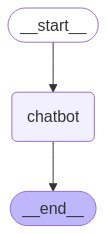

In [32]:
from IPython.display import Image, display

# 可视化展示这个工作流
try:
    display(Image(data=graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [35]:
from langchain.schema import AIMessage


def stream_graph_updates(user_input: str):
    # 向 graph 传入一条消息（触发状态更新 add_messages）
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            if "messages" in value and isinstance(value["messages"][-1], AIMessage):
                print("Assistant:", value["messages"][-1].content)


def run():
    # 执行这个工作流
    while True:
        user_input = input("User: ")
        if user_input.strip() == "":
            break

        stream_graph_updates(user_input)

In [36]:
run()

User:  你好


Assistant: 你好！有什么我可以帮助你的吗？


User:  今天心情好吗


Assistant: 谢谢你的关心！作为一个AI，我没有情感，但我很高兴能帮助你。有什么我可以为你做的吗？


User:  


### 4.3 加入 RAG 

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

# 加载文档
loader = PyMuPDFLoader("./data/deepseek-v3-1-4.pdf")
pages = loader.load_and_split()

# 文档切分
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=200,
    length_function=len,
    add_start_index=True,
)

texts = text_splitter.create_documents(
    [page.page_content for page in pages[:2]]
)

# 灌库
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
db = FAISS.from_documents(texts, embeddings)

# 检索 top-3 结果
retriever = db.as_retriever(search_kwargs={"k": 3})

In [38]:
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate

# Prompt模板
template = """请根据对话历史和下面提供的信息回答上面用户提出的问题:
{input}
"""
prompt = ChatPromptTemplate.from_messages(
    [
        HumanMessagePromptTemplate.from_template(template),
    ]
)

In [39]:
def retrieval(state: State):
    user_query = ""
    if len(state["messages"]) >= 1:
        # 获取最后一轮用户输入
        user_query = state["messages"][-1]
    else:
        return {"messages": []}
    # 检索
    docs = retriever.invoke(str(user_query))
    # 填 prompt 模板
    messages = prompt.invoke("\n".join([doc.page_content for doc in docs])).messages
    return {"messages": messages}

In [40]:
graph_builder = StateGraph(State)
graph_builder.add_node("retrieval", retrieval)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "retrieval")
graph_builder.add_edge("retrieval", "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [41]:
run()

User:  llama2有多少参数


Assistant: Llama 2有7B、13B和70B参数的版本。


User:  


### 4.4 加入分支：如果找不到答案则转人工

In [42]:
from langchain.schema import HumanMessage
from typing import Literal
from langgraph.types import interrupt, Command


def verify(state: State) -> Literal["chatbot", "ask_human"]:
    message = HumanMessage("请根据对话历史和上面提供的信息判断，已知的信息是否能够回答用户的问题。直接输出你的判断'Y'或'N'")
    ret = llm.invoke(state["messages"] + [message])
    if 'Y' in ret.content:
        return "chatbot"
    else:
        return "ask_human"


def ask_human(state: State):
    user_query = state["messages"][-2].content
    human_response = interrupt(
        {
            "question": user_query
        }
    )
    # Update the state with the human's input or route the graph based on the input.
    return {
        "messages": [AIMessage(human_response)]
    }


In [43]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()  # 用于持久化存储 state (这里以内存模拟）

graph_builder = StateGraph(State)

graph_builder.add_node("retrieval", retrieval)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("ask_human", ask_human)

graph_builder.add_edge(START, "retrieval")
graph_builder.add_conditional_edges("retrieval", verify)
graph_builder.add_edge("ask_human", END)
graph_builder.add_edge("chatbot", END)

# 中途会被转人工打断，所以需要 checkpointer 存储状态
graph = graph_builder.compile(checkpointer=memory)

In [44]:
from langchain.schema import AIMessage

# 当使用 checkpointer 时，需要配置读取 state 的 thread_id
# 可以类比 OpenAI Assistants API 理解，或者想象 Redis 中的 key 
thread_config = {"configurable": {"thread_id": "my_thread_id"}}


def stream_graph_updates(user_input: str):
    # 向 graph 传入一条消息（触发状态更新 add_messages）
    for event in graph.stream(
            {"messages": [{"role": "user", "content": user_input}]},
            thread_config
    ):
        for value in event.values():
            if isinstance(value, tuple):
                return value[0].value["question"]
            elif "messages" in value and isinstance(value["messages"][-1], AIMessage):
                print("Assistant:", value["messages"][-1].content)
                return None
    return None


def resume_graph_updates(human_input: str):
    for event in graph.stream(
            Command(resume=human_input), thread_config, stream_mode="updates"
    ):
        for value in event.values():
            if "messages" in value and isinstance(value["messages"][-1], AIMessage):
                print("Assistant:", value["messages"][-1].content)


def run():
    # 执行这个工作流
    while True:
        user_input = input("User: ")
        if user_input.strip() == "":
            break
        question = stream_graph_updates(user_input)
        if question:
            human_answer = input("Ask Human: " + question + "\nHuman: ")
            resume_graph_updates(human_answer)

In [ ]:
run()

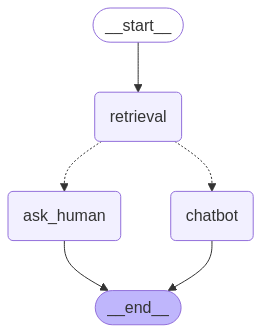

In [46]:
from IPython.display import Image, display

# 可视化展示这个工作流
try:
    display(Image(data=graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)